In [88]:
import numpy as np
import itertools
from itertools import chain, combinations, permutations, product
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

# First, we show that the 64 6-qubit states from the section "Dense coding with a shared dictionary" are indeed mutually orthonormal.

In [37]:
def powerset(iterable):
    '''
    Function to generate the powerset of a given iterable'''
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [38]:
def prepState(vec, pauliGates):
    '''
    Returns the Statevector 'vec', transformed by a list of pauli gates.
    '''
    circ = QuantumCircuit(vec.num_qubits)
    circ.initialize(vec)

    for i in range(len(pauliGates)):
        if (pauliGates[i] == 'x'):
            circ.x(i)
        elif (pauliGates[i] == 'y'):
            circ.y(i)
        elif (pauliGates[i] == 'z'):
            circ.z(i)

    return vec.evolve(circ)

In [58]:
N = 6

vec = np.zeros(2**N)

for i in range(2**N):
    # Binary representation of i
    binRep = bin(i)[2:].zfill(N)
    
    # Start with all odd parity states
    if np.sum(np.array(list(binRep)).astype(int))%2==1:
        # Add the appropriate negative phases
        if (binRep in set(['000111', '011100', '101010', '110001', '001110', '010101', '100011', '111000'])):
            vec[i] = -1
        else:
            vec[i] = 1

# Normalise
vec = Statevector(vec/np.sqrt(np.sum(vec**2)))

# Collect all possible states generated by Pauli gates on the first 3 qubits.
newStates = []
for pauliGates in list(product(['i', 'x', 'y', 'z'], repeat=3)):
    newStates.append(prepState(vec, pauliGates))

# Calculate their inner products:
innerProducts = np.zeros((len(newStates), len(newStates)))
for i in range(len(newStates)):
    for j in range(len(newStates)):
        innerProducts[i, j] = np.abs(np.dot(newStates[i].data, newStates[j].data))

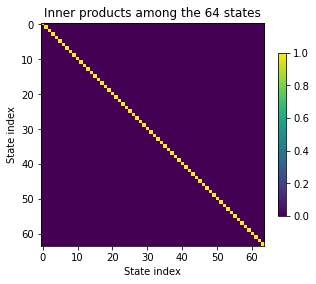

In [80]:
plt.figure(figsize=(5, 5))
plt.imshow(innerProducts)
plt.title('Inner products among the 64 states')
plt.xlabel('State index')
plt.ylabel('State index')
plt.colorbar(shrink=0.6)
plt.show()

# Now, we show that the hyperdeterminant of the n-coupled states is nonzero for n<10.

In [81]:
import sympy as sp
from sympy.solvers.solveset import linsolve

In [83]:
# Circuits to generate the different classes of states

def prepGHZ(nQ):
    ghz_circuit = QuantumCircuit(nQ)
    # Apply a Hadamard gate to the first qubit to create a superposition
    ghz_circuit.h(0)
    # Apply a series of CNOT gates to entangle all qubits
    for i in range(nQ - 1):
        ghz_circuit.cx(i, i + 1)
    return ghz_circuit

def prepEncoupled(N):
    circ = QuantumCircuit(N)
    for i in range(N-1):
        circ.h(i)
    
    for i in reversed(range(N-1)):
        circ.cnot(i, i+1)

    return circ

def W_state(N):
    circ = QuantumCircuit(N)
    state = Statevector.from_int(1, 2**N)

    for i in range(1, N):
        state = state + Statevector.from_int(2**i, 2**N)


    return 1/np.sqrt(N) * state

In [86]:
def solveTensorSystem(tensor):
    '''
    Solves the system of equations associated to a tensor's hyperderminant
    '''
    n = len(tensor.shape)
    # initialise symbolic variables, each with a binary index
    vars = sp.symarray('x', (n, 2), real=True)

    # Define the multilinear form, using the product function to generate all possible states
    f = sum([tensor[indices] * sp.prod([vars[i, indices[i]] for i in range(n)]) for indices in itertools.product([0, 1], repeat=n)])

    # The system of equations is given by the partial derivatives of f with respect to each variable
    eqs = tuple(f.diff(vars[i, j]) for i in range(n) for j in range(2))

    # Solve the system of equations
    sols = sp.solve(eqs, *vars.flatten())

    # Remove trivial solutions
    nonTrivSols = np.ones(len(sols)).astype(bool)
    for sol in range(len(sols)):
        for i in range(0, n*2, 2):
            if sols[sol][i]==0 and sols[sol][i+1]==0:
                nonTrivSols[sol]=False
    return np.array(sols)[nonTrivSols]

def fromStateToTensor(state):
    '''
    Converts a Statevector object to a complex numpy tensor.
    '''
    nQ = state.num_qubits
    tensor = np.zeros(tuple(2 for _ in range(nQ))) * 1j
    for indices in itertools.product([0, 1], repeat=nQ):
        tensor[indices] = state[int(''.join(str(x) for x in indices), 2)]

    return tensor

In [92]:
# Check if the hyperdeterminant of the W state is zero
# If there are any nontrivial solutions to the system of equations, then the hyperdeterminant is zero
for N in range(3, 11):
    state = W_state(N)
    tensor = fromStateToTensor(state)
    sols = solveTensorSystem(tensor)
    if len(sols)>0:
        print('HDET(W) = 0 for n =', N)
    else: 
        print('HDET(W) != 0 for n =', N)

HDET(W) = 0 for n = 3
HDET(W) = 0 for n = 4
HDET(W) = 0 for n = 5
HDET(W) = 0 for n = 6
HDET(W) = 0 for n = 7
HDET(W) = 0 for n = 8
HDET(W) = 0 for n = 9
HDET(W) = 0 for n = 10


In [93]:
for N in range(3, 11):
    state = Statevector.from_int(0, 2**N).evolve(prepGHZ(N))
    tensor = fromStateToTensor(state)
    sols = solveTensorSystem(tensor)
    if len(sols)>0:
        print('HDET(GHZ) = 0 for n =', N)
    else: 
        print('HDET(GHZ) != 0 for n =', N)

HDET(GHZ) != 0 for n = 3
HDET(GHZ) = 0 for n = 4
HDET(GHZ) = 0 for n = 5
HDET(GHZ) = 0 for n = 6
HDET(GHZ) = 0 for n = 7
HDET(GHZ) = 0 for n = 8
HDET(GHZ) = 0 for n = 9
HDET(GHZ) = 0 for n = 10


In [94]:
for N in range(3, 11):
    state = Statevector.from_int(0, 2**N).evolve(prepEncoupled(N))
    tensor = fromStateToTensor(state)
    sols = solveTensorSystem(tensor)
    if len(sols)>0:
        print('HDET(Encoupled) = 0 for n =', N)
    else: 
        print('HDET(Encoupled) != 0 for n =', N)

HDET(Encoupled) != 0 for n = 3
HDET(Encoupled) != 0 for n = 4
HDET(Encoupled) != 0 for n = 5
HDET(Encoupled) != 0 for n = 6
HDET(Encoupled) != 0 for n = 7
HDET(Encoupled) != 0 for n = 8
HDET(Encoupled) != 0 for n = 9


# Conclusion: as was proven in the paper, HDET(GHZ) = 0 for n>3, and HDET(W) = 0 for n>2. Furthermore, HDET(Encoupled) does not vanish up to at least n=10.